In [ ]:
#------------ Creating donations dataset --------------
#Importing pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Importing mkting channel datasets
instadata = pd.read_excel('/content/insta_final.xlsx')
fb_data = pd.read_excel('/content/Fb_final.xlsx')
twit_data = pd.read_excel('/content/twit_final.xlsx')
donations = pd.read_excel('/content/InformeDonacionesESADE3.xlsx')
newsletters = pd.read_excel('/content/NEWSLETTER.xlsx')
kantar = pd.read_excel('/content/Kantar_excel_edited.xlsx')

In [ ]:
#Viewing datasets
instadata.head()

,insta_id,Date,Post,Subtitle,Loose donation link,Video,Donation link,Likes,Comments,Total Interactions,Profile Visits,Website Taps (on profile page),Business Address Taps (in bio),Accounts Reached,Percentage not following BdA,Follows,Hashtag in post (Y/N),Hashtags in post,Emoji in post (Y/N),Number of Emojis,Link in post (Y/N),Posted Link,number of links in post,Collaboration (Y/N),Collaboration,post_id,Dominant Topic,Contribution %,Topic Terms,Caption length (figures)
0,0,02/04/2020,https://www.instagram.com/p/B-fN3HHoHy1/,📣 @mercadona dona más de 30.500 kilos de produ...,0.0,0,0,93,6,4,4,0,0,727,15,0,0,NaN,1,2.0,0,NaN,0,1,'@mercadona',1,1,27.08,"aliment, banc, famili, crisi, gracy, social, e...",274
1,1,02/04/2020,https://www.instagram.com/p/B-ekqgsoCcy/,La Fundació ”la Caixa” i CaixaBank impulsen un...,0.0,0,0,37,0,3,2,1,0,650,15,0,0,NaN,0,NaN,0,NaN,0,1,"'@caixabank', '@fundlacaixa'",2,1,29.60,"aliment, banc, famili, crisi, gracy, social, e...",175
2,2,03/04/2020,https://www.instagram.com/p/B-heDnnI8lt/,Del Banc dels Aliments de #Barcelona no paren ...,0.0,0,0,90,1,7,7,0,0,778,18,1,1,"'#Covid19!', '#Barcelona'",1,1.0,0,NaN,0,1,'@arroznomen',3,1,36.90,"aliment, banc, famili, crisi, gracy, social, e...",262
3,3,03/04/2020,https://www.instagram.com/p/B-hbxbgIV7a/,"💡 Abans, ajudar era important. ⚠ Ara, és impre...",0.0,1,0,25,1,0,0,0,0,759,26,0,1,"'#coronavirus,', '#NingúnHogarSinAlimentos'",1,1.0,0,NaN,0,1,'@fundlacaixa',4,4,31.29,"mes, ajudar, donacio, www, https, sms, mai, en...",235
4,4,03/04/2020,https://www.instagram.com/p/B-gtoPJIPG8/,📢 Más de 300.000 familias de nuestro país depe...,0.0,0,0,49,0,7,7,0,0,750,23,2,1,"'#coronavirus.', '#NingúnHogarSinAlimentos'",1,1.0,0,NaN,0,1,'@fundlacaixa',5,1,27.13,"aliment, banc, famili, crisi, gracy, social, e...",284


In [ ]:
#Standardizing date
instadata['Date'] = pd.to_datetime(instadata['Date'])
instadata['Date'] = instadata['Date'].dt.strftime('%Y-%m-%d')

In [ ]:
fb_data.head()

,fb_id,Caption,Post time,Post hour,Reach,Likes and Reactions,Comments,Shares,Link Clicks,Hashtag in post (Y/N),Number of hashtags,Hashtags in post,Emoji in post (Y/N),Number of Emojis,Link in post (Y/N),Posted Link,Donation Link (y/n),number of links in post,Collaboration (Y/N),Collaboration,Dominant Topic,Contribution %,Topic Terms,post length
0,1,Estem rodant! 🎬🎬🎬\nEn breu us presentarem la c...,2019-10-04,04:24:22,3245,139,1,20,136.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,1.0,25.47,"aliment, banc, campanya, social, euro, directo...",78
1,2,Ja som 9.631 persones voluntàries però ens ca...,2019-10-29,02:45:21,3549,85,3,40,120.0,1.0,2.0,"'#oliconservesllet', '#totelbarrivoluntari'",1.0,2.0,1.0,'https://www.granrecapte.com/ca/voluntariat/',0.0,1.0,0.0,NaN,2.0,32.75,"gran, ajudar, https, donacio, voluntari, dia, ...",605
2,3,Encara ens calen 15 mil persones voluntàries.\...,2019-11-13,00:38:49,5578,70,5,40,158.0,0.0,NaN,NaN,1.0,2.0,0.0,NaN,1.0,0.0,0.0,NaN,3.0,32.37,"mes, persona, fer, avui, necessitar, solidari,...",798
3,4,"Gran Recapte 2019. Siguis qui siguis, fes-te v...",2019-11-14,06:33:23,3299,67,5,28,139.0,0.0,NaN,NaN,0.0,NaN,1.0,'https://www.granrecapte.com/ca/voluntariat/',0.0,1.0,0.0,NaN,2.0,29.79,"gran, ajudar, https, donacio, voluntari, dia, ...",99
4,5,"🎙🎙Atenció, crida urgent!!!\nA cinc dies del Gr...",2019-11-18,03:15:09,6453,70,3,84,166.0,1.0,4.0,"'#oliconservesllet', '#posaelteugranet', '#Sig...",1.0,1.0,1.0,'https://www.granrecapte.com/ca/voluntariat/',0.0,1.0,0.0,NaN,2.0,32.66,"gran, ajudar, https, donacio, voluntari, dia, ...",377


In [ ]:
twit_data.head()

,Tweet id,Tweet permalink,tweet_text,Post date,Post hour,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,permalink clicks,app opens,app installs,follows,email tweet,dial phone,media views,media engagements,promoted impressions,promoted engagements,promoted engagement rate,promoted retweets,promoted replies,promoted likes,promoted user profile clicks,promoted url clicks,promoted hashtag clicks,promoted detail expands,promoted permalink clicks,promoted app opens,promoted app installs,promoted follows,promoted email tweet,promoted dial phone,promoted media views,promoted media engagements,Promoted,Hashtag in post (Y/N),Number of hashtags,Hashtags in post,Coronavirus (Y/N),Emoji in post (Y/N),Number of Emojis,Link in post (Y/N),Posted Link,Donation Link (Y/N),number of links in post,Collaboration (Y/N),Collaboration,post_id,post_id.1,Dominant Topic,Contribution %,Topic Terms
0,1085924788344893440,https://twitter.com/BancAlimentsBcn/status/108...,📌 Vols conèixer la dieta perfecta per salvar e...,2019-01-17,15,659,10,0.015175,1,0,3,0,4,0,2,0,0,0,0,0,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,NaN,NaN,0,1,1.0,1,'https://t.co/4n4YW4ffc5',0,1,1,'@elpaiscat',1,1,4,24.11,"https, sms, dona, daur, solidari, campanya, so..."
1,1088461307810992134,https://twitter.com/BancAlimentsBcn/status/108...,Des del Banc dels Aliments us animem a que us ...,2019-01-24,15,1936,15,0.007748,4,0,4,1,4,0,2,0,0,0,0,0,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,NaN,NaN,0,1,1.0,1,'https://t.co/reLuOtaGGm',0,1,1,'@OncolligaCAT',2,2,4,22.81,"https, sms, dona, daur, solidari, campanya, so..."
2,1088467229497270272,https://twitter.com/BancAlimentsBcn/status/108...,Pepi Labrador torna a l'escenari del Teatre Bl...,2019-01-24,16,1253,5,0.003990,0,0,2,1,0,0,1,0,0,0,0,0,0,1,1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,NaN,NaN,0,1,2.0,1,'https://t.co/zgeKfISODC',0,1,0,NaN,3,3,4,22.77,"https, sms, dona, daur, solidari, campanya, so..."
3,1090926970660155393,https://twitter.com/BancAlimentsBcn/status/109...,"Exposició de diorames, activitats infantils, s...",2019-01-31,10,1146,2,0.001745,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,NaN,NaN,0,1,1.0,1,'https://t.co/oZgfL418k0',0,1,1,'@barcelona_cat',4,4,4,31.14,"https, sms, dona, daur, solidari, campanya, so..."
4,1094543915917688832,https://twitter.com/BancAlimentsBcn/status/109...,Avui és el dia internacional de les llegums! S...,2019-02-10,10,1687,18,0.010670,2,1,9,0,0,1,2,0,0,0,0,0,0,3,3,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,1,3.0,"'#lovepulses', '#worldpulseday', '#proyectoleg...",0,1,1.0,1,'https://t.co/vIt5rORhPA',0,1,1,'@LegumechefSpain',5,5,4,25.19,"https, sms, dona, daur, solidari, campanya, so..."


In [ ]:
#Deleting unnecessary columns
twit_data.drop(columns=['post_id', 'post_id.1'], inplace=True)
instadata.drop(columns=['post_id'], inplace=True)

In [ ]:
donations.head()

,Identificador de contribución,Tipo de Contacto,Tipo de donación,Fecha donación,Importe,Campaña,Ciudad,Código postal,Lattitude,Longitude,Provincia,País,Country English,Forma de Pago,Periodicidad
0,7353,Organization,Periodic donation,2019-01-01,30.0,NaN,Begues,8859,41.3333,1.9333,NaN,España,Spain,Rebut domiciliat,Mensual
1,7403,Organization,Periodic donation,2019-01-01,25.0,NaN,Cervelló,8758,41.3959,1.9592,Barcelona,España,Spain,Rebut domiciliat,Mensual
2,7457,Organization,Periodic donation,2019-01-01,50.0,NaN,Barcelona,8028,41.3888,2.1590,Barcelona,España,Spain,Rebut domiciliat,Mensual
3,7496,Organization,Periodic donation,2019-01-01,10.0,NaN,Sant Celoni,8470,41.6833,2.4833,Barcelona,España,Spain,Rebut domiciliat,Mensual
4,7508,Organization,Periodic donation,2019-01-01,25.0,NaN,L'Hospitalet De Llobregat,8907,41.4301,2.1925,Barcelona,España,Spain,Rebut domiciliat,Mensual


In [ ]:
#Removing 2021 data from donations
donations201920 = donations[donations['Fecha donación'] < '2021-01-01']

In [ ]:
newsletters.head()

,Nombre,Fecha,Time (hour),Enviados,Abiertos,% open,Clicks,Sin abrir,Quejas,Hards,Softs,Bajas
0,Producte recuperat Mercabarna 2019 - Producto ...,2020-01-27,14,5669,1736,0.306227,170,3714,1,7,195,13
1,Agrïment donants aliments 2019,2020-02-12,15,511,290,0.567515,5,207,0,9,4,2
2,Donacions monetàries web 2019,2020-02-13,16,103,49,0.475728,2,53,0,1,0,0
3,Crida voluntairat Alimentaria 2020,2020-02-19,16,875,515,0.588571,18,354,0,0,3,0
4,Donants aliments 2019 SC,2020-02-20,13,21,11,0.523810,0,10,0,0,0,0


In [ ]:
kantar.head()

,Titular,Tipo de Fuente,Fuente,Programa,Medio,Fecha de publicación,Fecha de entrega,Hora de entrega,País,Autor,Sentimiento,Superficie,AVE,OTS,Usuarios únicos,NumberOfPages,Extracto,URL,Categorías,Tipo de contenido,Id,Número de páginas,Resúmenes,Usuarios únicos.1,Visitas (x1000),Source GMD Id
0,60 titulars per resumir l’any 2020,Portal,@ ELTOTBADALONA.CAT,NaN,Web,2020-12-31 12:00:00,2020-12-31,21,España,NaN,Negativo,0.0,0.0,0,NaN,1,Els treballadors de Can Casacuberta tanquen la...,https://www.eltotbadalona.cat/60-titulars-per-...,BANC DELS ALIMENTS,Noticias,ES8147826_0400031947089100,NaN,Els treballadors de Can Casacuberta tanquen la...,NaN,NaN,25596338.0
1,La X Carrera Fundación Fernando Alonso recauda...,Portal,@ LAF1.ES,NaN,Web,2020-12-31 12:00:00,2020-12-31,18,España,NaN,Neutro,0.0,0.0,0,NaN,1,La décima edición ha tenido lugar de forma vir...,https://soymotor.com/noticias/carrera-fundacio...,FESBAL,Noticias,ES8147826_0400031946793500,NaN,La décima edición ha tenido lugar de forma vir...,NaN,NaN,500706.0
2,El músic Tom Trovador: “Ara venc del Banc d’Al...,Portal,@ IB3.ORG,NaN,Web,2020-12-31 12:00:00,2020-12-31,18,España,NaN,Neutro,0.0,23.0,2300,47000.0,1,La pandèmia ha provocat la pitjor crisi de la ...,https://ib3.org/el-music-tom-trovador-ara-venc...,BANC DELS ALIMENTS,Noticias,ES8147826_0400031946793300,NaN,La pandèmia ha provocat la pitjor crisi de la ...,47000.0,47000.0,538824.0
3,"FOTOS | Así ha vivido Albacete el 2020, el año...",Portal,@ ELDIGITALDEALBACETE.COM,NaN,Web,2020-12-31 12:00:00,2020-12-31,15,España,NaN,Positivo,0.0,869.0,86900,931000.0,1,El año 2020 quedará marcado en la historia de ...,https://www.eldigitaldealbacete.com/2020/12/31...,FESBAL,Noticias,ES8147826_0400031945584800,NaN,El año 2020 quedará marcado en la historia de ...,931000.0,931000.0,498299.0
4,Cerca de un millar de participantes en la X Ca...,Portal,@ EL COMERCIO DIGITAL,NaN,Web,2020-12-31 12:00:00,2020-12-31,15,España,NaN,Positivo,0.0,9137.0,913700,5866000.0,1,La X edición de la prueba contó con un total d...,https://www.elcomercio.es/deportes/atletismo/c...,FESBAL,Noticias,ES8147826_0400031945573600,NaN,La X edición de la prueba contó con un total d...,5866000.0,5866000.0,1961465.0


In [ ]:
#Creating dataset to match date to channels used on that date

channels_used__per_day = pd.DataFrame({})

for day in set(kantar['Fecha de entrega']):
  per_date = kantar[kantar['Fecha de entrega'] == day]
  web = []
  print = []
  radio = []
  tv = []
  for medium in set(per_date['Medio']):
    if medium == 'Web':
      web.append(1)
      print.append(0)
      radio.append(0)
      tv.append(0)
    elif medium == 'Prensa':
      web.append(0)
      print.append(1)
      radio.append(0)
      tv.append(0)
    elif medium == 'Radio':
      web.append(0)
      print.append(0)
      radio.append(1)
      tv.append(0)
    elif medium == 'tv':
      web.append(0)
      print.append(0)
      radio.append(0)
      tv.append(1)

  #Add to dataframe
  per_day = pd.DataFrame({'Web used today (Y/N)': max(web), 'Print used today (Y/N)' : max(print), 
                          'Radio used today (Y/N)' : max(radio), 'TV used today (Y/N)' : max(tv)},
                         index = [day])
  #Adding to cross-date dataframe for later join with main kantar data
  channels_used__per_day = channels_used__per_day.append(per_day)


In [ ]:
#Adding the media-specific columns for the kantar dataset
#To fix problem of multiple posts per day at later stage
#And retain information about media channel

kantar_incl_channels = kantar.set_index('Fecha de entrega').join(channels_used__per_day)

In [ ]:
#Putting back the date column for later code
kantar_incl_channels.reset_index(inplace=True)
kantar_incl_channels = kantar_incl_channels.rename(columns = {'index':'Fecha de entrega'})

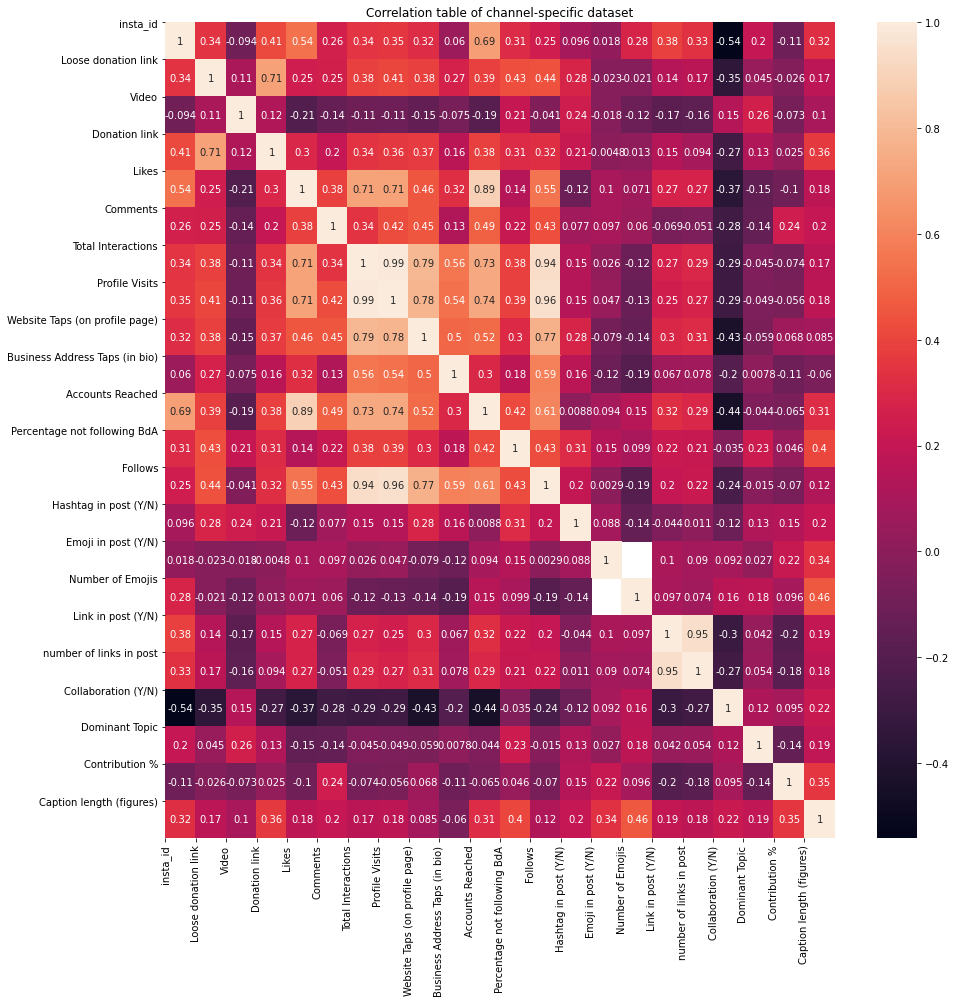

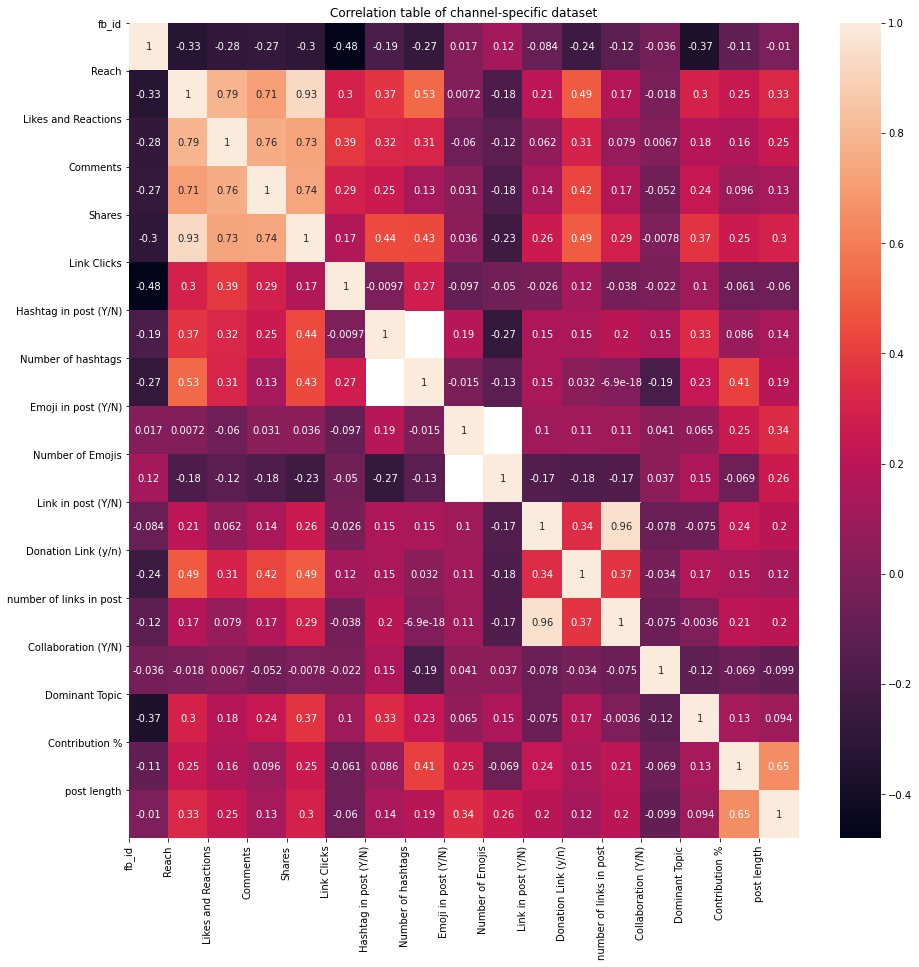

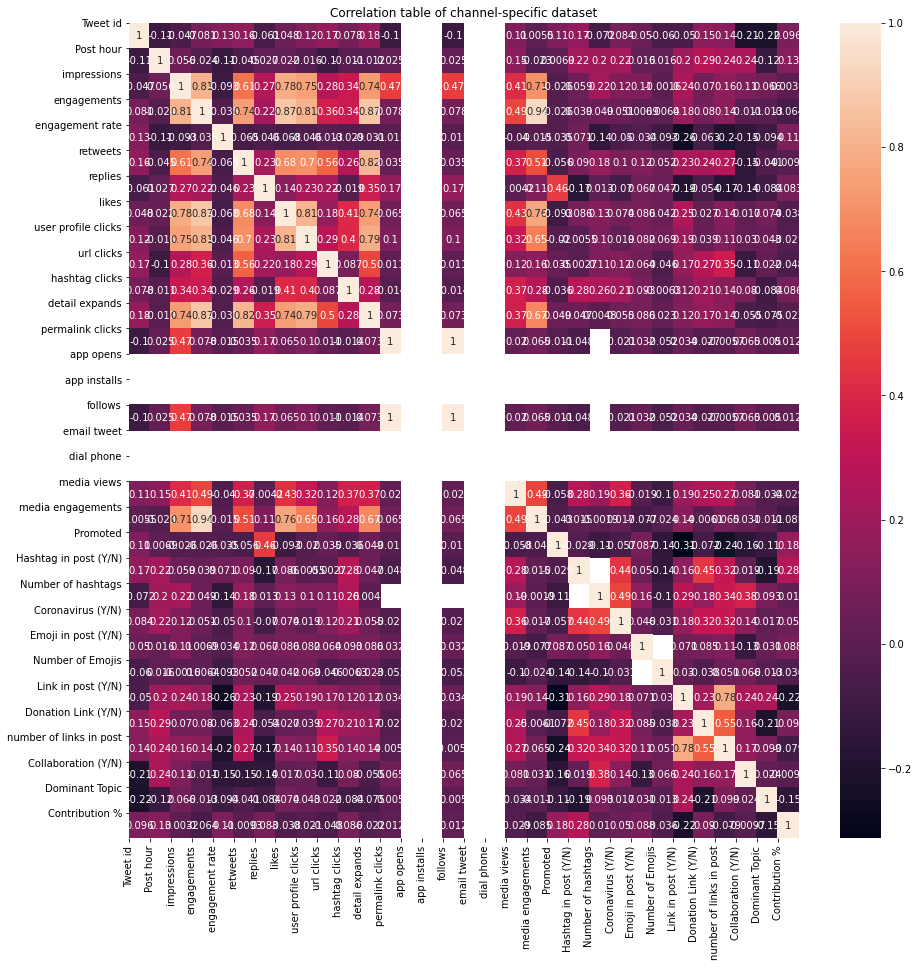

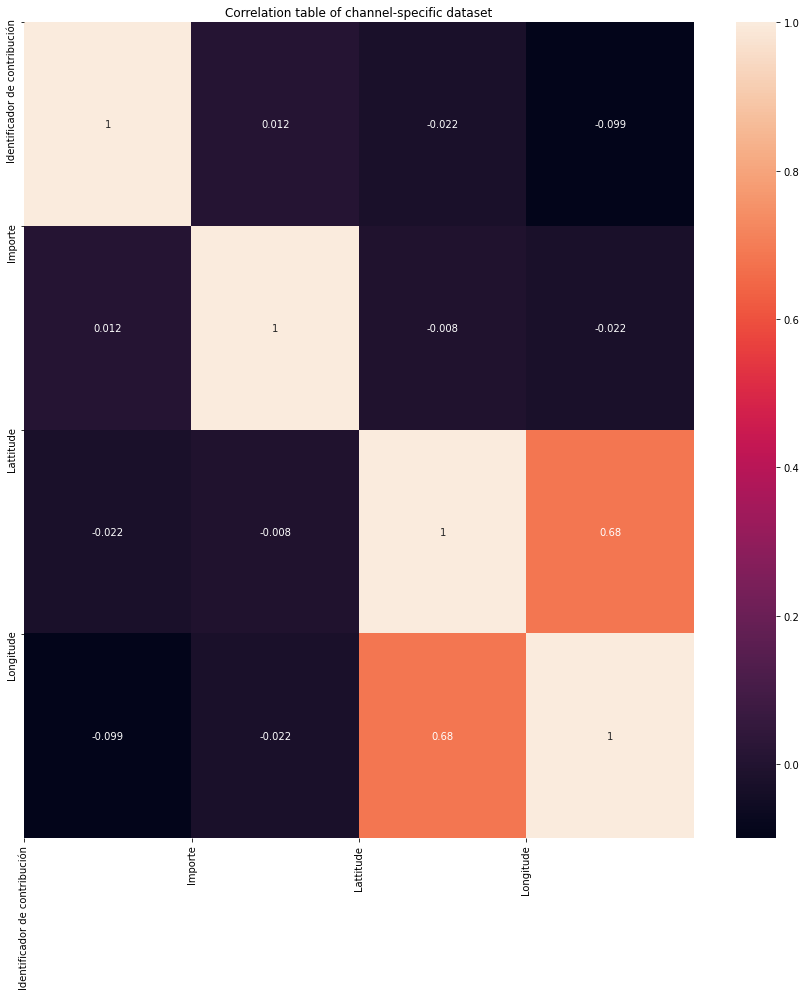

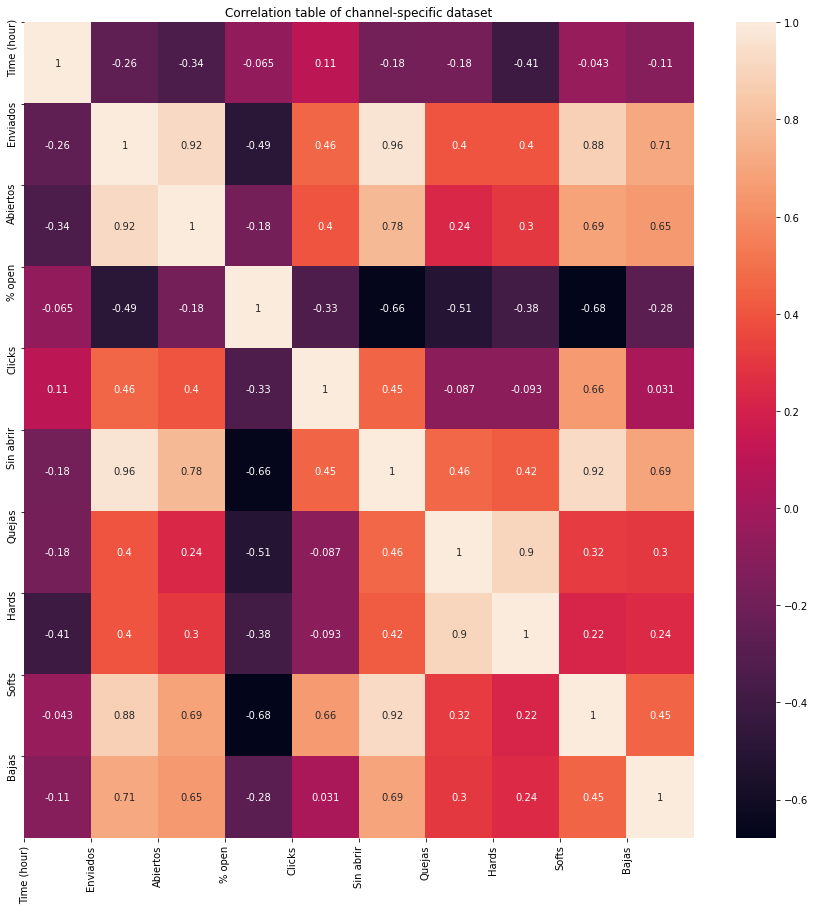

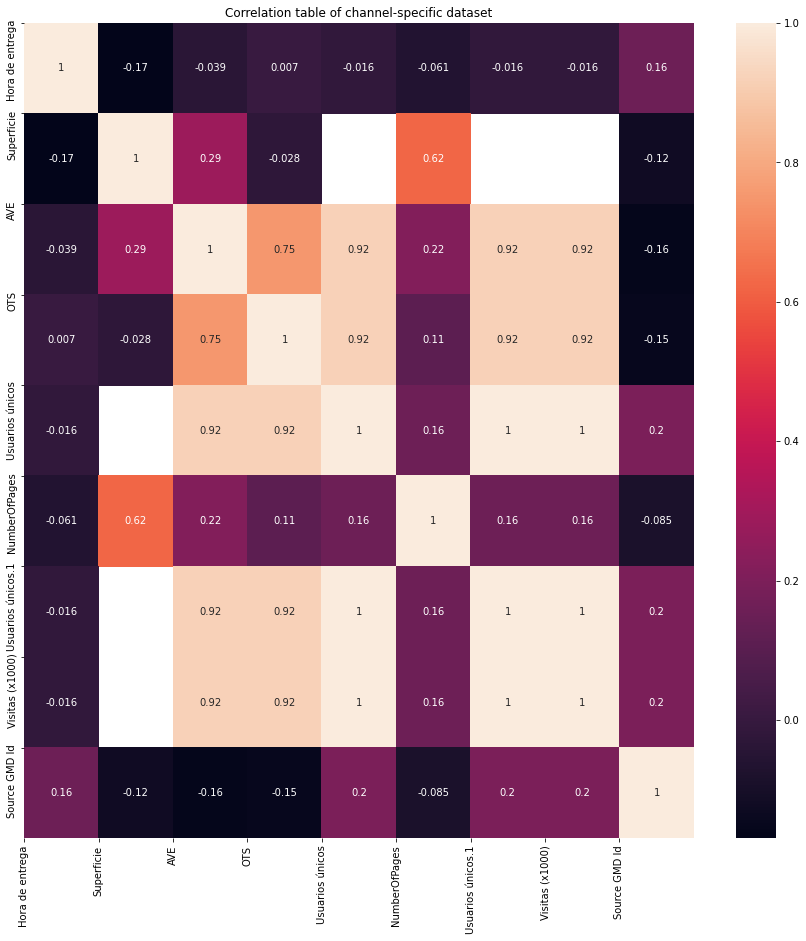

In [ ]:
#Checking correlations within datasets
import seaborn as sns

for dataset in [instadata, fb_data, twit_data, donations201920, newsletters, kantar]:
  corr = dataset.corr(method='pearson')
  labels = [c for c in corr.columns]  # get label names

  fig = plt.figure(figsize=(15,15))  # figure so we can add axis
  ax = sns.heatmap(corr, annot=True)  # define axis, so we can modify
  #ax.imshow(corr, cmap=plt.cm.RdYlGn)  # display the matrix
  ax.set_xticks(np.arange(len(labels)))  # show them all
  ax.set_yticks(np.arange(len(labels)))  # show them all
  ax.set_xticklabels(labels)  # set to be the labels (vs useless #)
  ax.set_yticklabels(labels)  # set to be the labels (vs useless #)

  plt.xticks(rotation=90)
  plt.title(f'Correlation table of channel-specific dataset')

  plt.show()

In [ ]:
#Counting posts for each date
def count_posts(date_column, channel_name):
  rslt = pd.DataFrame({'date':date_column.value_counts().index,
              f'{channel_name}_posts': date_column.value_counts()})
  return rslt

In [ ]:
#Creating new dataset counting posts for each date
insta_counts = count_posts(instadata['Date'], 'Instagram')
fb_counts = count_posts(fb_data['Post time'], 'Facebook')
twitter_counts = count_posts(twit_data['Post date'], 'Twitter')
kantar_counts = count_posts(kantar_incl_channels['Fecha de entrega'], 'Kantar')
newsletter_counts = count_posts(newsletters['Fecha'], 'Newsletter')

In [ ]:
#Creating key dataset
key = pd.DataFrame({'date': pd.date_range(start="2019-01-01",end="2020-12-31")})
#Joining datasets
channels_counts = key.set_index('date').join(insta_counts.set_index('date'))
channels_counts = channels_counts.join(fb_counts.set_index('date'))
channels_counts = channels_counts.join(twitter_counts.set_index('date'))
channels_counts = channels_counts.join(kantar_counts.set_index('date'))
channels_counts = channels_counts.join(newsletter_counts.set_index('date'))

In [ ]:
channels_counts

,Instagram_posts,Facebook_posts,Twitter_posts,Kantar_posts,Newsletter_posts
date,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN
2019-01-02,NaN,NaN,NaN,NaN,NaN
2019-01-03,NaN,NaN,NaN,NaN,NaN
2019-01-04,NaN,NaN,NaN,NaN,NaN
2019-01-05,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-12-27,NaN,1.0,NaN,17.0,NaN
2020-12-28,NaN,4.0,NaN,39.0,NaN
2020-12-29,NaN,1.0,NaN,40.0,NaN


In [ ]:
#Replacing NaNs with 0's
channels_counts.fillna(0, inplace = True)

#Adding total posts per day column
channels_counts['total_social_media_posts_on_day_excl_kantar'] = channels_counts.sum(axis = 1)-channels_counts['Kantar_posts']
channels_counts['total_social_media_posts_on_day_incl_kantar'] = channels_counts.sum(axis = 1)-channels_counts['total_social_media_posts_on_day_excl_kantar']
#Adding binary column specifying any SM post
channels_counts['Social_Media_post_Y/N_excl_kantar'] = channels_counts[
  'total_social_media_posts_on_day_excl_kantar'].apply(lambda x: 1 if x > 0 else 0)
channels_counts['Social_Media_post_Y/N_incl_kantar'] = channels_counts[
  'Kantar_posts'].apply(lambda x: 1 if x > 0 else 0)


In [ ]:
#Adding counts of posts per channel to donations
dons_cnts = donations201920.set_index('Fecha donación').join(channels_counts)


In [ ]:
#Checking
dons_cnts.to_csv('/content/donations_etc.csv')

In [ ]:
#Filtering out most popular posts for each channel
#To fix the problem of having multiple posts on a single day and channel
#And having no timestamp for the donation to couple it to a individual post
def max_per_date(dataset, date_column_name, popularity_metric):
  rslt = pd.DataFrame(columns=list(dataset.columns))
  
  for date in list(set(dataset[date_column_name])):

    if len(dataset[dataset[date_column_name] == date]) > 1:
      
      inter = dataset[(dataset[date_column_name] == date) & 
          (dataset[popularity_metric] == (dataset[dataset[date_column_name] == date][popularity_metric].max()))]
      
      #To handle problem that kantar has many posts on a given day
      #We take only the first entry
      #We try to retain some data about value of different channels with the
      #Binary columns of whether there was a post through a certain channels on
      #a given day as done before
      if len(inter) > 1:
        inter = dataset[dataset[date_column_name] == date].head(1)
        rslt = rslt.append(inter)
      else:
        rslt = rslt.append(inter)

    else:    
      df = dataset[dataset[date_column_name] == date]
      rslt = rslt.append(df)

  return rslt

In [ ]:
kantar_best = max_per_date(kantar_incl_channels, 'Fecha de entrega', 'Visitas (x1000)')

In [ ]:
#Creating 'best-per-day' dataset for each channel
insta_best = max_per_date(instadata, 'Date', 'Accounts Reached')
fb_best = max_per_date(fb_data, 'Post time', 'Reach')
twit_best = max_per_date(twit_data, 'Post date', 'impressions')
kantar_best = max_per_date(kantar, 'Fecha de entrega', 'Visitas (x1000)')
newsletter_best = max_per_date(newsletters, 'Fecha', '% open')

In [ ]:
#Joining best-per-day datasets with donations dataset to get full dataset
dons_full = dons_cnts.join(insta_best.set_index('Date'), rsuffix='_insta')
dons_full = dons_full.join(fb_best.set_index('Post time'), rsuffix='_fb')
dons_full = dons_full.join(twit_best.set_index('Post date'), rsuffix='_twit')
dons_full = dons_full.join(kantar_best.set_index('Fecha de entrega'), rsuffix='_kantar')
dons_full = dons_full.join(newsletter_best.set_index('Fecha'), rsuffix='_newsletter')

In [ ]:
#Exporting to csv for further analysis
dons_full.to_csv('/content/donations_full.csv')

In [ ]:
dons_full['Identificador de contribución'].nunique()

83692

In [ ]:
len(dons_full['Identificador de contribución'])

83692

In [ ]:
#---------'New Dataset'-------------
#Creating dataset for every day, containing donations on that day and SM posts
#for that day to try and measure effect of SM on donations
donations_counts = count_posts(donations201920['Fecha donación'], 'Donations')
#Standardizing date
donations_counts['date'] = pd.to_datetime(donations_counts['date'])
donations_counts['date'] = donations_counts['date'].dt.strftime('%Y-%m-%d')
donations_counts.set_index('date')

,Donations_posts
date,
2020-12-31,23047
2020-11-21,5082
2020-11-16,4122
2020-11-20,3104
2020-11-17,2273
...,...
2020-11-16,1
2020-11-16,1
2019-10-26,1


In [ ]:
#Creating function to make dataset to sum values on certain date

def sum_day(dataset, date_column, var_column, var_name):
  var_per_day = pd.DataFrame({})

  for day in set(dataset[date_column]):
    per_date_filter = dataset[dataset[date_column] == day]
    
    #Add to dataframe
    per_day_df = pd.DataFrame({f'Total_{var_name}' : sum(per_date_filter[var_column])},
                              index = [day])
  
    #Adding to cross-date dataframe for later join with main data
    var_per_day = var_per_day.append(per_day_df)

  return var_per_day

In [ ]:
new_dataset = 0

In [ ]:
#Donations
donations_value = sum_day(donations201920, 'Fecha donación', 'Importe', 'Value_Dons_on_Day')

#Split empresas/individuals
donations_empresas = donations201920[donations201920['Tipo de Contacto'] == 'Organization']
donations_indiv = donations201920[donations201920['Tipo de Contacto'] == 'Individual']

empresas_count = count_posts(donations_empresas['Fecha donación'], 
                             'Empresa_donations_posts')
empresas_value = sum_day(donations_empresas, 'Fecha donación', 
                         'Importe', 'Value Empresa_Dons_on_Day')

individuals_count = count_posts(donations_indiv['Fecha donación'], 
                                'Individuals_donations_posts')
individuals_value = sum_day(donations_indiv, 'Fecha donación', 
                            'Importe', 'Value_Individual_Dons_on_Day')

#Adding to main dataframe
new_dataset = donations_counts.join([donations_value, empresas_count.set_index('date'), empresas_value, 
                                     individuals_count.set_index('date'), individuals_value])

In [ ]:
#Instagram
insta_day_likes = sum_day(instadata, 'Date', 'Likes', 'Insta_Likes')
insta_day_comments = sum_day(instadata, 'Date', 'Comments', 'Insta_Comments')
insta_day_accts_reached = sum_day(instadata, 'Date', 'Accounts Reached', 'Insta_Reach')
insta_day_follows = sum_day(instadata, 'Date', 'Follows', 'Insta_Follows')
insta_day_interacts = sum_day(instadata, 'Date', 'Total Interactions', 'Insta_Interactions')

In [ ]:
#Merging insta with new dataset
dfs_insta = [insta_day_likes, insta_day_comments, insta_day_accts_reached, insta_day_follows, insta_day_interacts]
insta_dataset = dfs_insta[0].join(dfs_insta[1:])

In [ ]:
#Solving problem with joining instagram columns
new_dataset = new_dataset.join(insta_dataset)

In [ ]:
#Facebook
fb_day_likes = sum_day(fb_data, 'Post time', 'Likes and Reactions', 'FB_Likes')
fb_day_comments = sum_day(fb_data, 'Post time', 'Comments', 'FB_Comments')
fb_day_shares = sum_day(fb_data, 'Post time', 'Shares', 'FB_Shares')
fb_day_accts_reached = sum_day(fb_data, 'Post time', 'Reach', 'FB_Reach')
fb_day_linkclicks = sum_day(fb_data, 'Post time', 'Link Clicks', 'FB_Interactions')

In [ ]:
#Merging FB with new dataset
dfs_fb = [fb_day_likes, fb_day_comments, fb_day_accts_reached, fb_day_shares, fb_day_linkclicks]
new_dataset = new_dataset.join(dfs_fb)

In [ ]:
#Twitter
twit_day_likes = sum_day(twit_data, 'Post date', 'likes', 'Twit_Likes')
twit_day_engagements = sum_day(twit_data, 'Post date', 'engagements', 'Twit_Engagements')
twit_day_retweets = sum_day(twit_data, 'Post date', 'retweets', 'Twit_Retweets')
twit_day_impressions = sum_day(twit_data, 'Post date', 'impressions', 'Twit_Impressions')
twit_day_replies = sum_day(twit_data, 'Post date', 'replies', 'Twit_replies')
twit_day_linkclicks = sum_day(twit_data, 'Post date', 'url clicks', 'Twit_clicks')
twit_day_hashclicks = sum_day(twit_data, 'Post date', 'hashtag clicks', 'Twit_hashclicks')

In [ ]:
#Merging Twitter with new dataset
dfs_twit = [twit_day_likes, twit_day_engagements, twit_day_retweets, twit_day_impressions, 
          twit_day_replies, twit_day_linkclicks, twit_day_hashclicks]
new_dataset = new_dataset.join(dfs_twit)

In [ ]:
newsletters.head(1)

,Nombre,Fecha,Time (hour),Enviados,Abiertos,% open,Clicks,Sin abrir,Quejas,Hards,Softs,Bajas
0,Producte recuperat Mercabarna 2019 - Producto ...,2020-01-27,14,5669,1736,0.306227,170,3714,1,7,195,13


In [ ]:
#Newsletter
news_day_sent = sum_day(newsletters, 'Fecha', 'Enviados', 'Sent_emails')
news_day_open = sum_day(newsletters, 'Fecha', 'Abiertos', 'Opened_Emails')
news_day_clicks = sum_day(newsletters, 'Fecha', 'Clicks', 'Email_clicks')
news_day_notopen = sum_day(newsletters, 'Fecha', 'Sin abrir', 'Emails_not_opened')
news_day_softbounce = sum_day(newsletters, 'Fecha', 'Softs', 'Email_soft_bounces')

In [ ]:
#Merging newsletter data with new dataset
dfs_news = [news_day_sent, news_day_open, news_day_clicks, news_day_notopen, 
          news_day_softbounce]
new_dataset = new_dataset.join(dfs_news)

#filling NaNs with 0's
new_dataset.fillna(0, inplace = True)

In [ ]:
#Creating function to aggregate the posts of a certain fuente in kantar
def fuente_day(fuente_name):
  var_per_day = pd.DataFrame({})

  for day in set(kantar['Fecha de entrega']):
    per_date_filter = kantar[(kantar['Fecha de entrega'] == day) & 
                             (kantar['Fuente'] == fuente_name)]
    
    #Add to dataframe
    per_day_df = pd.DataFrame({f'{fuente_name}_perday' : len(per_date_filter),
                               f'{fuente_name}_AVE_day': sum(per_date_filter['AVE'])},
                              index = [day])
  
    #Adding to cross-date dataframe for later join with main data
    var_per_day = var_per_day.append(per_day_df)

  return var_per_day

In [ ]:
#Kantar
kantar_TV3 = fuente_day('TV3')
kantar_nacional = fuente_day('@ ELNACIONAL.CAT')
kantar_digitalnacio = fuente_day('@ NACIÓ DIGITAL')
kantar_diari = fuente_day('@ ARA.CAT')
kantar_vanguardia1 = fuente_day('@ LA VANGUARDIA')
kantar_vanguardia2 = fuente_day('La Vanguardia')
kantar_vanguardia3 = fuente_day('La Vanguardia Dinero')
kantar_vanguardia4 = fuente_day('La Vanguardia Vivir')
kantar_periodico1 = fuente_day('El Periódico de Catalunya')
kantar_periodico2 = fuente_day('El Periódico de Catalunya Más Periódico')
kantar_periodico3 = fuente_day('@ EL PERIÓDICO DE CATALUNYA')
kantar_periodico4 = fuente_day('@ELPERIODICO.CAT')


In [ ]:
#Merging with larger dataset
dfs_kntr = [kantar_TV3, kantar_nacional, kantar_digitalnacio,
            kantar_diari, kantar_vanguardia1, kantar_vanguardia2,
            kantar_vanguardia3, kantar_vanguardia4, kantar_periodico1, 
            kantar_periodico2, kantar_periodico3, kantar_periodico4]
new_dataset = new_dataset.join(dfs_kntr)

In [ ]:
#Merging with channel counts to get final dataset
new_dataset = new_dataset.join(channels_counts)

In [ ]:
#Setting date as index 
new_dataset.set_index('date')

,Donations_posts,Total_Value_Dons_on_Day,Empresa_donations_posts_posts,Total_Value Empresa_Dons_on_Day,Individuals_donations_posts_posts,Total_Value_Individual_Dons_on_Day,Total_Insta_Likes,Total_Insta_Comments,Total_Insta_Reach,Total_Insta_Follows,Total_Insta_Interactions,Total_FB_Likes,Total_FB_Comments,Total_FB_Reach,Total_FB_Shares,Total_FB_Interactions,Total_Twit_Likes,Total_Twit_Engagements,Total_Twit_Retweets,Total_Twit_Impressions,Total_Twit_replies,Total_Twit_clicks,Total_Twit_hashclicks,Total_Sent_emails,Total_Opened_Emails,Total_Email_clicks,Total_Emails_not_opened,Total_Email_soft_bounces,TV3_perday,TV3_AVE_day,@ ELNACIONAL.CAT_perday,@ ELNACIONAL.CAT_AVE_day,@ NACIÓ DIGITAL_perday,@ NACIÓ DIGITAL_AVE_day,@ ARA.CAT_perday,@ ARA.CAT_AVE_day,@ LA VANGUARDIA_perday,@ LA VANGUARDIA_AVE_day,La Vanguardia_perday,La Vanguardia_AVE_day,La Vanguardia Dinero_perday,La Vanguardia Dinero_AVE_day,La Vanguardia Vivir_perday,La Vanguardia Vivir_AVE_day,El Periódico de Catalunya_perday,El Periódico de Catalunya_AVE_day,El Periódico de Catalunya Más Periódico_perday,El Periódico de Catalunya Más Periódico_AVE_day,@ EL PERIÓDICO DE CATALUNYA_perday,@ EL PERIÓDICO DE CATALUNYA_AVE_day,@ELPERIODICO.CAT_perday,@ELPERIODICO.CAT_AVE_day,Instagram_posts,Facebook_posts,Twitter_posts,Kantar_posts,Newsletter_posts,total_social_media_posts_on_day_excl_kantar,total_social_media_posts_on_day_incl_kantar,Social_Media_post_Y/N_excl_kantar,Social_Media_post_Y/N_incl_kantar
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-31,23047.0,3450507.27,393.0,2161636.63,22654.0,1288870.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,32.0,0.0,1.0
2020-11-21,5082.0,278023.00,25.0,3580.00,5057.0,274443.00,0.0,0.0,0.0,0.0,0.0,129.0,1.0,4646.0,34.0,43.0,21.0,154.0,17.0,5536.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,42750.0,0.0,0.0,2.0,8322.0,0.0,0.0,3.0,195291.0,1.0,5253.0,0.0,0.0,2.0,45678.0,1.0,19458.28,0.0,0.0,1.0,15520.0,0.0,0.0,0.0,4.0,4.0,90.0,0.0,8.0,98.0,1.0,1.0
2020-11-16,4122.0,256256.00,21.0,6500.00,4101.0,249756.00,399.0,16.0,2549.0,25.0,266.0,388.0,10.0,15820.0,191.0,115.0,35.0,488.0,62.0,13018.0,3.0,51.0,0.0,30262.0,14703.0,1859.0,14769.0,604.0,4.0,42755.0,4.0,29256.0,3.0,12483.0,1.0,1560.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,148.0,1.0,9.0,157.0,1.0,1.0
2020-11-20,3104.0,181182.00,24.0,9302.00,3080.0,171880.00,277.0,6.0,1860.0,0.0,33.0,229.0,4.0,4742.0,43.0,39.0,15.0,47.0,6.0,1952.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,39465.0,2.0,14628.0,0.0,0.0,2.0,3120.0,6.0,390582.0,1.0,15450.0,0.0,0.0,2.0,12670.0,2.0,10845.90,0.0,0.0,3.0,46560.0,0.0,0.0,1.0,3.0,3.0,315.0,0.0,7.0,322.0,1.0,1.0
2020-11-17,2273.0,202901.00,35.0,38125.00,2238.0,164776.00,78.0,0.0,1071.0,0.0,5.0,55.0,0.0,3444.0,20.0,224.0,14.0,66.0,18.0,6110.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62700.0,0.0,0.0,2.0,8322.0,0.0,0.0,2.0,130194.0,0.0,0.0,0.0,0.0,1.0,3090.0,0.0,0.00,0.0,0.0,1.0,15520.0,0.0,0.0,1.0,5.0,2.0,300.0,0.0,8.0,308.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-16,1.0,50.00,0.0,0.00,1.0,50.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-16,1.0,150.00,0.0,0.00,1.0,150.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-26,1.0,20.00,0.0,0.00,1.0,20.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
#Downloading excel
new_dataset.to_excel('SM_to_dons.xlsx')

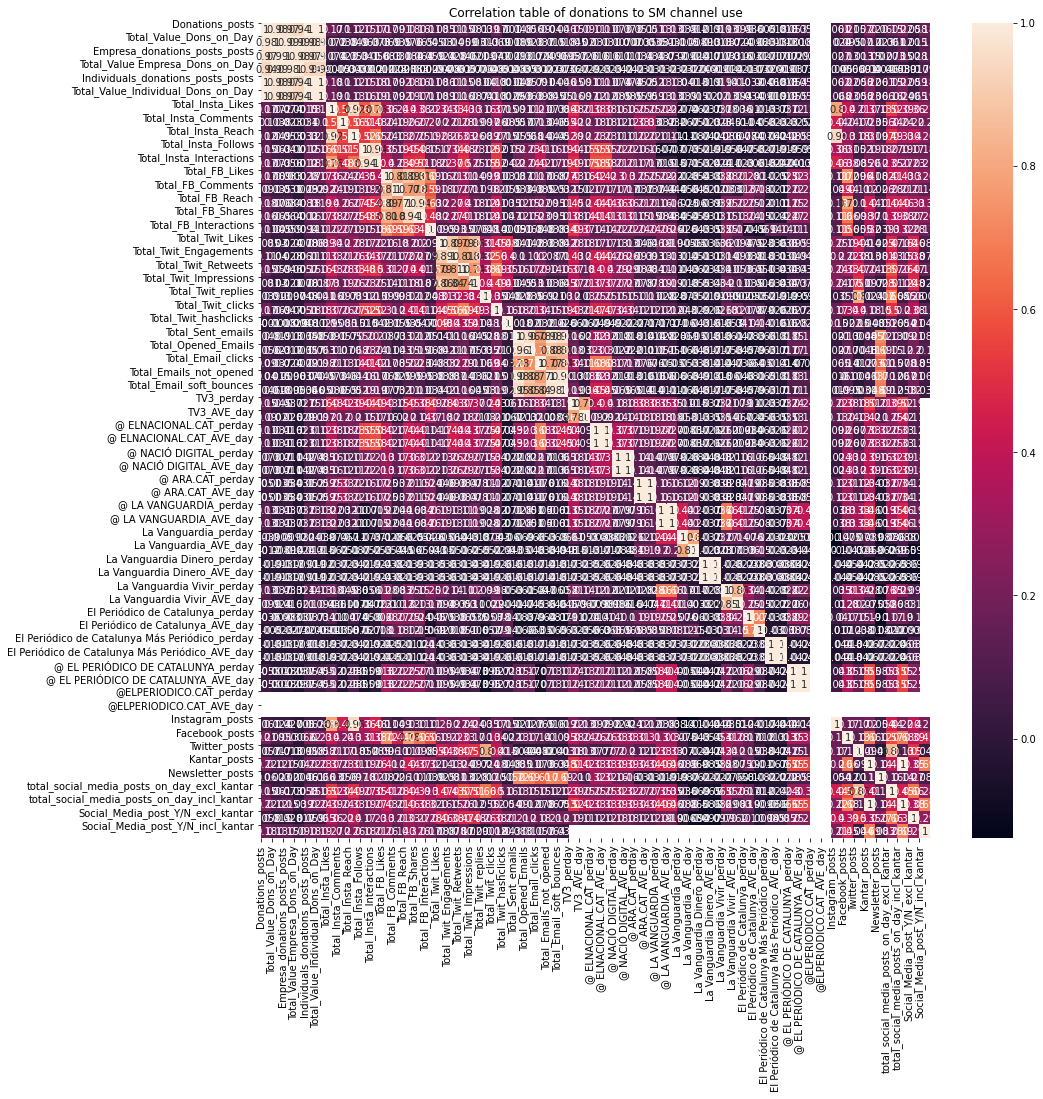

In [ ]:
#Checking correlation (and collinearity)
corr_new = new_dataset.corr(method='pearson')
labels = [c for c in corr_new.columns]  # get label names

fig = plt.figure(figsize=(15,15))  # figure so we can add axis
ax = sns.heatmap(corr_new, annot=True)  # define axis, so we can modify
#ax.imshow(corr, cmap=plt.cm.RdYlGn)  # display the matrix
ax.set_xticks(np.arange(len(labels)))  # show them all
ax.set_yticks(np.arange(len(labels)))  # show them all
ax.set_xticklabels(labels)  # set to be the labels (vs useless #)
ax.set_yticklabels(labels)  # set to be the labels (vs useless #)

plt.xticks(rotation=90)
plt.title(f'Correlation table of donations to SM channel use')

plt.show()

In [ ]:
list(new_dataset.columns)

['date',
 'Donations_posts',
 'Total_Value_Dons_on_Day',
 'Empresa_donations_posts_posts',
 'Total_Value Empresa_Dons_on_Day',
 'Individuals_donations_posts_posts',
 'Total_Value_Individual_Dons_on_Day',
 'Total_Insta_Likes',
 'Total_Insta_Comments',
 'Total_Insta_Reach',
 'Total_Insta_Follows',
 'Total_Insta_Interactions',
 'Total_FB_Likes',
 'Total_FB_Comments',
 'Total_FB_Reach',
 'Total_FB_Shares',
 'Total_FB_Interactions',
 'Total_Twit_Likes',
 'Total_Twit_Engagements',
 'Total_Twit_Retweets',
 'Total_Twit_Impressions',
 'Total_Twit_replies',
 'Total_Twit_clicks',
 'Total_Twit_hashclicks',
 'Total_Sent_emails',
 'Total_Opened_Emails',
 'Total_Email_clicks',
 'Total_Emails_not_opened',
 'Total_Email_soft_bounces',
 'TV3_perday',
 'TV3_AVE_day',
 '@ ELNACIONAL.CAT_perday',
 '@ ELNACIONAL.CAT_AVE_day',
 '@ NACIÓ DIGITAL_perday',
 '@ NACIÓ DIGITAL_AVE_day',
 '@ ARA.CAT_perday',
 '@ ARA.CAT_AVE_day',
 '@ LA VANGUARDIA_perday',
 '@ LA VANGUARDIA_AVE_day',
 'La Vanguardia_perday',
 'La V

In [ ]:
#Defining function that adds campaigns to each of the datasets we created,
#so we can evaluate the success of certain campaigns across SM channels
def add_campaign(dataset, date_column):
  campaign = []
  dona_aliments = []
  gr = []
  
  #Looping across days and adding value if within date range of campaign
  for day in dataset[date_column]:
    if day in pd.date_range(start="2020-03-16",end="2020-07-31"):
      campaign.append('dona aliments')
      dona_aliments.append(1)
      gr.append(0)
    elif day in pd.date_range(start="2020-10-23",end="2020-12-16"):
      campaign.append('gran recapte')
      dona_aliments.append(0)
      gr.append(1)
    else:
      campaign.append('')
      dona_aliments.append(0)
      gr.append(0)
  
  #Adding to dataset
  dataset['Campaign'] = campaign
  dataset['Dona Aliments campaign (y/n)'] = dona_aliments
  dataset['Grand Recapte campaign (y/n)'] = gr

In [ ]:
#Creating date column in dons full to join with campaign 
dons_full['date'] = dons_full.index

In [ ]:
#Removing time
dons_full['date'] = pd.to_datetime(dons_full['date'])
dons_full['date'] = dons_full['date'].dt.strftime('%Y-%m-%d')

In [ ]:
#Adding to all datasets
add_campaign(twit_data, 'Post date')
add_campaign(fb_data, 'Post time')
add_campaign(instadata, 'Date')
add_campaign(kantar, 'Fecha de entrega')
add_campaign(newsletters, 'Fecha')
add_campaign(dons_full, 'date')
add_campaign(new_dataset, 'date')

In [ ]:
#Saving as csv for later analysis
instadata.to_csv('/content/insta_final_cmpgn.csv')
twit_data.to_csv('/content/twit_final_cmpgn.csv')
fb_data.to_csv('/content/fb_final_cmpgn.csv')
kantar.to_csv('/content/kantar_final_cmpgn.csv')
newsletters.to_csv('/content/newsletters_cmpgn.csv')
dons_full.to_csv('/content/donations_incl_cmpgn.csv')
new_dataset.to_csv('/content/SM_to_dons_incl_cmpgn.csv')